# EKF SLAM Comparison to Dead Reckoning
In this example we consider a differential drive robot with a range-bearing sensor that observes various landmarks in the environment. We will have the robot drive a square trajectory through the world, and then compare using dead-reckoning and EKF SLAM to estimate the trajectory driven by the robot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
import time
from slam import *

np.random.seed(3)  # stable example

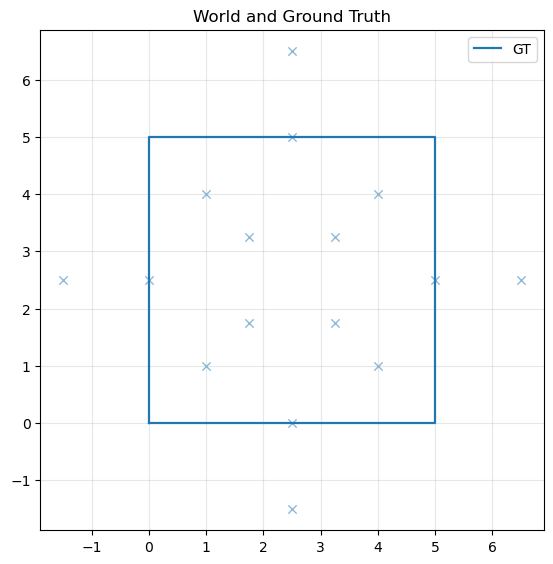

In [2]:
# Create simple world
world = make_simple_world()

# Define robot and the various covariances for its measurements
sensor_range = 0.9 * (np.sqrt(2)*world.side_length)  # see many LMs on each side
odom_cov = np.diag([0.03**2, 0.03**2, (np.deg2rad(1.0))**2])
range_bearing_cov = np.diag([0.20**2, (np.deg2rad(2.0))**2])
loop_closure_cov = 0.2 * odom_cov
robot = Robot(odom_cov=odom_cov, 
              range_bearing_cov=range_bearing_cov, 
              loop_closure_cov=loop_closure_cov, 
              sensor_range=sensor_range)

# Simulate a square trajectory and compute simulated measurements
dt = 0.1
controls = square_loop_control_sequence(world, v=0.25, dt=dt)
x_gt, odom_meas, lm_meas, _ = simulate(robot, world, controls, dt)

# Plot the world's landmarks and ground truth robot trajectory
plot_traj("World and Ground Truth", {"GT": x_gt}, world)

### Odometry-Only Localization (Dead Reckoning)
In this first example we have the simplest and least accurate approach that is based on only odometry measurements where the robot is using its own sensors to estimate its motion (e.g. using wheel encoders). Specifically, we use the `odom_meas` outputs from the robot's simulated trajectory computed above.

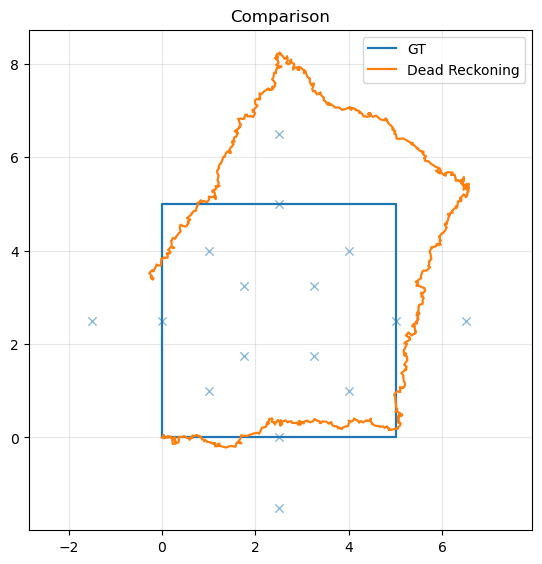

=== Error metric and execution time ===
Odometry only: 2.352 m, time: 16.18 ms


In [3]:
def dead_reckoning(odom_meas: np.ndarray) -> np.ndarray:
    T = odom_meas.shape[0]
    x = np.zeros((T+1, 3))
    for t, rel in enumerate(odom_meas):
        x[t+1] = se2_compose(x[t], rel)
    return x

# Compute odometry based trajectory estimate and compare to ground-truth
start_time = time.perf_counter()
x_odom = dead_reckoning(odom_meas)
time_odom = time.perf_counter() - start_time
plot_traj("Comparison", {"GT": x_gt, "Dead Reckoning": x_odom}, world)
rmse_odom = absolute_trajectory_rmse(x_gt, x_odom)
print("=== Error metric and execution time ===")
print(f"Odometry only: {rmse_odom:.3f} m, time: {1000*time_odom:.2f} ms")

### Filter-based Approach: EKF SLAM
The EKF SLAM algorithm leverages the extended Kalman filter approach in the context of a SLAM problem to maintain joint Gaussian over robot poses and landmarks.

In [4]:
class EKFSLAM:
    def __init__(self, M: int):
        self.M = M # number of landmarks to track
        self.x = np.zeros(3 + 2*M) # [x, y, th, l1x l1y, ...]
        self.P = np.eye(3 + 2*M) * 1e6
        self.P[0:3,0:3] = np.diag([1e-6, 1e-6, 1e-6])
        self.have_lm = np.zeros(M, dtype=bool)

    def predict(self, u, dt, control_cov):
        v, w = u
        x, y, th = self.x[0:3]
        if abs(w) < 1e-9:
            x_new = x + v*dt*np.cos(th)
            y_new = y + v*dt*np.sin(th)
            th_new = th
            Fx = np.array([[1, 0, -v*dt*np.sin(th)],
                           [0, 1,  v*dt*np.cos(th)],
                           [0, 0,  1]])
            Fu = np.array([[dt*np.cos(th), 0],
                           [dt*np.sin(th), 0],
                           [0, dt]])
        else:
            r = v/w; dth = w*dt
            x_new = x - r*np.sin(th) + r*np.sin(th + dth)
            y_new = y + r*np.cos(th) - r*np.cos(th + dth)
            th_new = wrap_angle(th + dth)
            Fx = np.array([[1, 0, -r*np.cos(th) + r*np.cos(th + dth)],
                           [0, 1, -r*np.sin(th) + r*np.sin(th + dth)],
                           [0, 0, 1]])
            Fu = np.array([[dt*np.cos(th), 0],
                           [dt*np.sin(th), 0],
                           [0, dt]])
        self.x[0:3] = np.array([x_new, y_new, th_new])
        G = np.eye(len(self.x)); G[0:3,0:3] = Fx
        V = np.zeros((len(self.x), 2)); V[0:3,:] = Fu
        self.P = G @ self.P @ G.T + V @ control_cov @ V.T

    def init_landmark(self, j, z):
        r, b = z
        x, y, th = self.x[0:3]
        lx = x + r*np.cos(b + th)
        ly = y + r*np.sin(b + th)
        self.x[3+2*j:3+2*j+2] = [lx, ly]
        self.have_lm[j] = True
        self.P[3+2*j:3+2*j+2, 3+2*j:3+2*j+2] = np.diag([0.5, 0.5])

    def update(self, j, z, R):
        if not self.have_lm[j]:
            self.init_landmark(j, z)
        lx, ly = self.x[3+2*j:3+2*j+2]
        x, y, th = self.x[0:3]
        dx, dy = lx - x, ly - y
        q = dx*dx + dy*dy
        r_pred = np.sqrt(q)
        b_pred = wrap_angle(np.atan2(dy, dx) - th)
        z_pred = np.array([r_pred, b_pred])

        H = np.zeros((2, len(self.x)))
        H[0,0] = -dx / r_pred; H[0,1] = -dy / r_pred; H[0,2] = 0.0
        H[1,0] =  dy / q;      H[1,1] = -dx / q;      H[1,2] = -1.0
        H[0,3+2*j]   =  dx / r_pred
        H[0,3+2*j+1] =  dy / r_pred
        H[1,3+2*j]   = -dy / q
        H[1,3+2*j+1] =  dx / q

        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        yk = z - z_pred; yk[1] = wrap_angle(yk[1])

        self.x = self.x + K @ yk
        self.x[2] = wrap_angle(self.x[2])
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

### Run EKF SLAM
Run the code below to run the EKF Slam algorithm and compare against dead-reckoning.

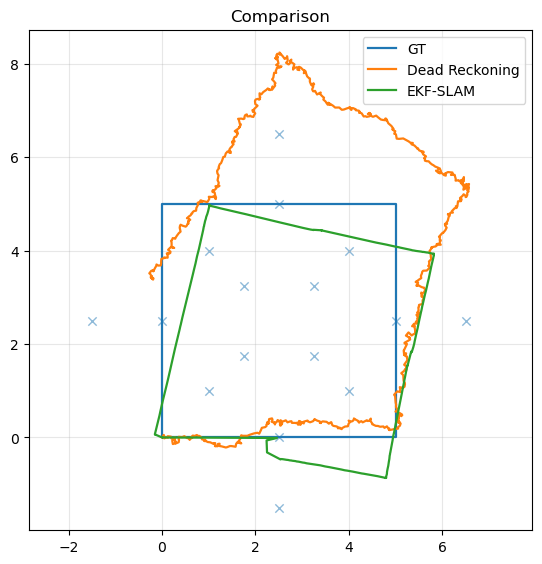

=== Error metric and execution time ===
Odometry only      : 2.352 m, time: 16.18 ms
EKF-SLAM           : 0.827 m, time: 827.90 ms


In [5]:
def run_ekf_slam(robot: Robot, world: World, controls: List[Tuple[float, float]], dt: float, lm_meas, control_cov: np.ndarray):
    ekf = EKFSLAM(M=world.num_landmarks())
    T = len(controls)
    x_ekf = np.zeros((T+1, 3))
    for t, u in enumerate(controls):
        ekf.predict(u, dt, control_cov)
        for (j, z) in lm_meas[t+1]:
            ekf.update(j, z, robot.range_bearing_cov)
        x_ekf[t] = ekf.x[0:3].copy()
    return x_ekf

# Run EKF SLAM and compare results
control_cov = np.diag([0.06**2, (np.deg2rad(2.0))**2])     # control noise (v,w)
start_time = time.perf_counter()
x_ekf = run_ekf_slam(robot, world, controls, dt, lm_meas, control_cov)
time_ekf = time.perf_counter() - start_time
plot_traj("Comparison", {"GT": x_gt, "Dead Reckoning": x_odom, "EKF-SLAM": x_ekf}, world)
rmse_ekf = absolute_trajectory_rmse(x_gt, x_ekf)
print("=== Error metric and execution time ===")
print(f"Odometry only      : {rmse_odom:.3f} m, time: {1000*time_odom:.2f} ms")
print(f"EKF-SLAM           : {rmse_ekf:.3f} m, time: {1000*time_ekf:.2f} ms")